<a href="https://colab.research.google.com/github/JennyPre/ReinforcementSimple/blob/main/AutonomousCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
! pip install gymnasium
! pip install gymnasium stable-baselines3
! pip install mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00


In [17]:
import gymnasium as gym
import torch.nn as nn
import torch
import mediapy as media
import numpy as np
import torch.optim as optim

In [30]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')

# run a few episodes with random actions
frames = []
observation, info = env.reset()
rewards = []


for t in range(10000):
  action = env.action_space.sample()
  frames.append(env.render())
  observation, reward, terminated, truncated, info = env.step(action)
  done = terminated or truncated # is termianted, when the car has position 0.45
  rewards.append(reward)

  if done:
    print(f"Episode finished after {t+1} timesteps. Cummulative return: {sum(rewards)}")
    break

media.show_video(frames, fps=50, loop=True)

Episode finished after 999 timesteps. Cummulative return: -33.04583109429998


### Action

$$action \in{[-1, 1]}$$
- represents the force applied to the car:

  - **-1** = push left with full force
  - **0** = no force
  - **+1** = push right with full force
  - **0.5** = push right with half force

### Reward & Magnitude

$$magnitude = | action | $$
$$reward = -0.1 × action²$$

Hence **Larger magnitude = bigger penalty**


In [74]:
print(np.mean(rewards)) # the problem is hard, random actions wont solve it
#  With random actions averaging around ±0.5 magnitude, you get small penalties each step, and since you never reached the goal (+100 bonus), you only accumulated negative rewards.
# quick math: 0.5 * 0.5 = 0.25 --> align with mean reward

-0.03307891000430428


## Policy Gradient

- learn a probablity distribution --> sample action
- Whats the probability for each action?


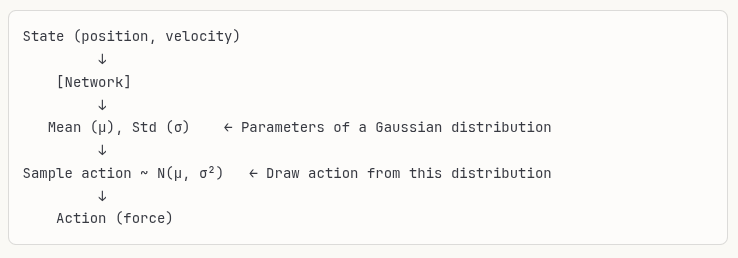


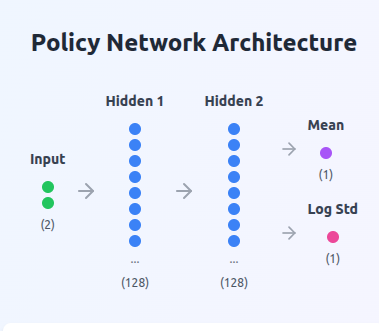

In [76]:
class PolicyNetwork(nn.Module):

    def __init__(self, state_size):
      super(PolicyNetwork, self).__init__()

      # state_size=2 (position, velocity)
      # action_size=1 (acceleration) sampled from resulting distribution

      self.fc1 = nn.Linear(state_size, 128)  # First layer: 2 -> 128  AKA position and velocity
      self.fc2 = nn.Linear(128, 128)         # Hidden layer: 128 -> 128

      self.mean_layer = nn.Linear(128, 1)
      self.log_std_layer = nn.Linear(128, 1)

    def forward(self, x):
        """Pass the state through the network to get the parameters for the distribution"""

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        mean = torch.tanh(self.mean_layer(x)) # tanh to bound between -1 and 1
        log_std = torch.clamp(self.log_std_layer(x), -20, 2) #  prevent extreme values

        return mean, log_std

    def sample_action(self, state):
        """Sample an action from the output distribution"""
        mean, log_std = self.forward(state)
        std = log_std.exp() # Transform from log-space to actual std: e^(log_std) is always > 0
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob # Return log_prob as a tensor

In [59]:
policyNet = PolicyNetwork(2)
action, log_prob = policyNet.sample_action(torch.tensor([0.0, 0.0]))
print(f"Got action {action} and log prob {log_prob}")

Got action -1.5257923603057861 and log prob tensor([-2.0662], grad_fn=<SubBackward0>)


### Policy Gradient algorithm


#### 1. Collect data from episode

store states, actions, rewards, and how likely each action was (log probability)


#### 2. Compute returns

Discounted sum of future rewards: **How much total reward did I get from this point forward?**

#### 3. Update policy

$$Loss = -log\_prob(action) * return$$




In [72]:
class PolicyAgent:
  """The RL Agent that learns to get the car up the hill"""
  def __init__(self, state_size, action_size):
    self.gamma = 0.99  # Discount factor
    self.num_episodes = 1000
    self.lr = 0.001

    self.policy_net = PolicyNetwork(state_size)
    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

  def run_episode(self, observation):
    """Collect the data from one episode.
    The returnes values will later be used to train the policy network"""

    # TODO: which parameters do i need to send to here?
    rewards = []
    log_probs = []
    done = False

    actions = []
    observations = []

    while not done:
      # TODO: how do i get this log prob?
      action, log_prob = self.policy_net.sample_action(observation) # TODO: observation is the same as state?
      actions.append(action)
      log_probs.append(log_prob)

      observation, reward, terminated, truncated, _ = env.step(action) # if steps > 999 --> truncate
      rewards.append(reward)
      done = terminated or truncated # is termianted, when the car has position 0.45

      if terminated:
        print(f"Reward gotten for success {reward}, is this 100?")

      rewards.append(reward) # rewards are +100 on termination, +1, -1 ...

    return rewards, observations, actions

  def compute_returns(self, rewards):
    """Computes the returns (G) for each time step of an episode
    is done in an iterative Backward manner """
    G = 0
    returns = [(G := r + self.gamma * G) for r in reversed(rewards)]
    return torch.tensor(list(reversed(returns)), dtype=torch.float32)

  def calculate_loss(self, log_probs, returns):
    """Calculates the loss with some normalization"""
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    return -sum(log_p * G for log_p, G in zip(log_probs, returns))

  def train(self, num_episodes, env):
    for t in range(num_episodes):
      state = env.reset()
      print(f"state: {state}")

      rewards, log_probs = self.run_episode(state)
      returns = self.compute_returns(rewards)
      loss = self.calculate_loss(log_probs, returns)

      # TODO: is update policy done via the backpropagation?
      # TODO: sample random batch from memory - not needed

      # calculate the distribution and sample the propability to take action?
      # calc loss done

      # backprop
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()




In [73]:
# agent = PolicyAgent(env.observation_space.shape[0], env.action_space.shape[0])
agent = PolicyAgent(2,1)
agent.train(10, env)

state: (array([-0.5818105,  0.       ], dtype=float32), {})


TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple

In [ ]:
# optimizer
# prediction
# visualization




- import sac for stable-baselines3
- create a simple traing loop
- save the model
- test it ...


### SAC - Soft Actor-Critic

- continuous action and state space
- Actor Critic
- for precise continuous control
- more advanced

